### 计算图是PyTorch对于神经网络的具体实现形式，包括每一个数据Tensor及Tensor之间的函数function。

以z= ωx+ b为例，通常在神经网络中，x为输入，ω与b为网络需要学习的参数，z为输出，在这一层，计算图构建方法如图所示。

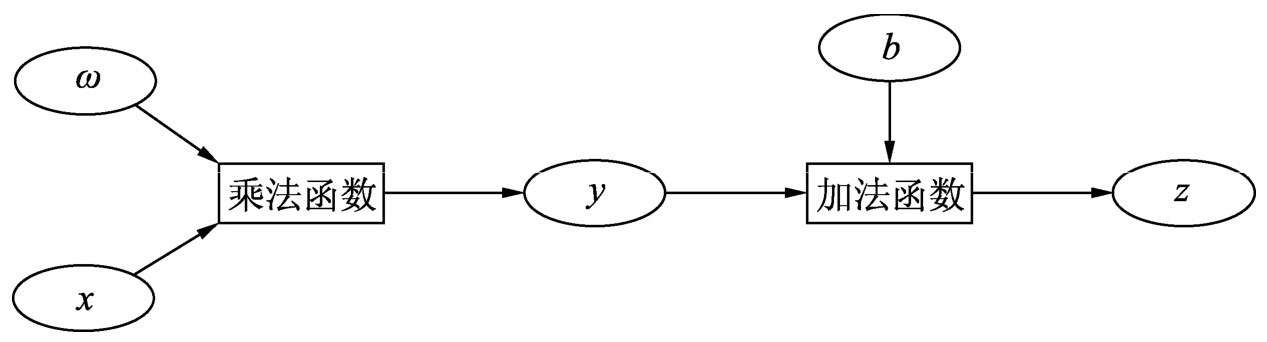

在上图中，x、ω和b都是用户自己创建的，因此都为叶节点，ωx首先经过乘法算子产生中间节点y，然后与b经过加法算法产生最终输出z，并作为根节点。

## Autograd的基本原理

随着每一步Tensor的计算操作，逐渐生成计算图，并将操作的function记录在Tensor的grad_fn中。在前向计算完后，只需对根节点进行backward函数操作，即可从当前根节点自动进行反向传播与梯度计算，从而得到每一个叶子节点的梯度，梯度计算遵循链式求导法则。

In [1]:
import torch

In [2]:
#生成3个Tensor变量，并做为叶节点
x = torch.randn(1)
w = torch.ones(1, requires_grad=True)
b = torch.ones(1, requires_grad=True)
x, w, b

(tensor([-0.2225]),
 tensor([1.], requires_grad=True),
 tensor([1.], requires_grad=True))

In [3]:
#自己生成的Tensor，均为叶节点
x.is_leaf, w.is_leaf, b.is_leaf

(True, True, True)

In [4]:
#进行前向计算，由计算生成的变量都不是叶节点
y = w*x
z = y+b
y.is_leaf, z.is_leaf

(False, False)

In [5]:
#由于依赖的变量有需要求导的，因此y与z都需要求导
y.requires_grad, z.requires_grad

(True, True)

In [6]:
#grad_fn记录了生成该变量经过了什么操作
y.grad_fn

In [7]:
#grad_fn记录了生成该变量经过了什么操作
z.grad_fn

In [8]:
#对根节点调用backward()函数，进行梯度反转
z.backward(retain_graph=True)
w.grad, b.grad

(tensor([-0.2225]), tensor([1.]))

## Autograd注意事项

①**动态图特性**：PyTorch建立的计算图是动态的，这也是PyTorch的一大特点。动态图是指程序运行时，每次前向传播时从头开始构建计算图，这样不同的前向传播就可以有不同的计算图，也可以在前向时插入各种Python的控制语句，不需要事先把所有的图都构建出来，并且可以很方便地查看中间过程变量。

②**backward()函数还有一个需要传入的参数grad_variabels，其代表了根节点的导数，也可以看做根节点各部分的权重系数**。因为PyTorch不允许Tensor对Tensor求导，求导时都是标量对于Tensor进行求导，因此，如果根节点是向量，则应配以对应大小的权重，并求和得到标量，再反传。如果根节点的值是标量，则该参数可以省略，默认为1。

③当有多个输出需要同时进行梯度反传时，需要**将retain_graph设置为True，从而保证在计算多个输出的梯度时互不影响**。